#Checkpoint 4: Redes Neuronales



Enunciado:

* Construir una red neuronal para clasificación y mejorar su performance mediante la búsqueda de arquitectura e hiperparámetros adecuados.
* Evaluar la performance de todos los modelos en entrenamiento y validación, explicar todas las métricas y mostrar la matriz de confusión.
* Generar predicciones con el conjunto de test y realizar los submits correspondientes en la competencia de Kaggle.
* Generar las conclusiones finales del trabajo práctico evaluando la performance de todos los modelos entrenados.

## Importamos librerías y datasets

Importamos librerías:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

!pip install keras-tuner --upgrade
!pip install keras==2.12.0
import pandas as pd
import numpy as np
#librerias para visualizar los datos
import matplotlib.pyplot as plt
import seaborn as sns

#modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score,accuracy_score,f1_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import time
import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.12.0 which is incompatible.
Using TensorFlow backend


Montamos Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos datasets:

In [ ]:
ds_hoteles_train = pd.read_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/hoteles_train_exportado.csv')
ds_hoteles_test = pd.read_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/hotels_test.csv')
ds_paises_continentes = pd.read_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/tabla_pais_continente.csv')

### Hacemos la copia de los datasets

In [ ]:
ds_hoteles_train_copy = ds_hoteles_train.copy()
ds_hoteles_test_copy = ds_hoteles_test.copy()
ds_paises_continentes_copy = ds_paises_continentes.copy()

### Definimos funciones

In [ ]:
def plot_regression(modelo,x,y,title="",xlabel="x",ylabel="y"):
    plt.figure()

    plt.plot(x,y,"o",label="Valores verdaderos")
    plt.plot(x,modelo.predict(x),"x",label="Valores estimados")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

## Realizamos transformaciones

Realizamos las mismas transformaciones que en el checkpoint anterior:

### En train

In [ ]:
#country / nombre_continente
moda_country = ds_hoteles_train_copy['country'].mode().iloc[0]
ds_hoteles_train_copy['country'].fillna(moda_country, inplace=True)
ds_hoteles_train_copy['country'].unique()

ds_paises_continentes_copy.rename(columns={'alpha-3': 'country', 'region': 'nombre_continente'}, inplace=True)
ds_hoteles_train_copy = pd.merge(ds_hoteles_train_copy, ds_paises_continentes_copy[['country','nombre_continente']],on='country', how='left')

ds_hoteles_train_copy.loc[ds_hoteles_train_copy['country'] == 'CN', 'nombre_continente'] = "Asia"
ds_hoteles_train_copy.loc[ds_hoteles_train_copy['country'] == 'ATA', 'nombre_continente'] = "Antartica"

ds_hoteles_train_copy.drop(['country'], axis=1, inplace=True)

#arrival_time
ds_hoteles_train_copy['arrival_date'] = pd.to_datetime(ds_hoteles_train_copy['arrival_date'])
ds_hoteles_train_copy['arrival_date'] = ds_hoteles_train_copy['arrival_date'].astype(int)

#One-hot encoding
vars_a_onehot = ['hotel','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type','meal','nombre_continente']

#Les aplicamos One Hot Encoding
ds_hoteles_train_copy = pd.get_dummies(ds_hoteles_train_copy, columns=vars_a_onehot, drop_first=True)

### En test

In [ ]:
#Obtengo la moda
moda_country = ds_hoteles_test_copy['country'].mode().iloc[0]

#Reemplazar los NaN por la moda de 'country'
ds_hoteles_test_copy['country'].fillna(moda_country, inplace=True)

#Obtenemos un nuevo dataframe, donde unimos las columnas de hoteles_test_copy y df_Tabla_Pais_Continente_copy
ds_hoteles_test_copy = pd.merge(ds_hoteles_test_copy,ds_paises_continentes_copy[['country','nombre_continente']],on='country', how='left')

#Reemplazamos los valores de continente donde eran NaN (o NULL)
ds_hoteles_test_copy.loc[ds_hoteles_test_copy['country'] == 'CN', 'nombre_continente'] = "Asia"
ds_hoteles_test_copy.loc[ds_hoteles_test_copy['country'] == 'ATA', 'nombre_continente'] = "Antartica"

#Eliminamos la variable country
ds_hoteles_test_copy.drop(['country'], axis=1, inplace=True)

In [ ]:
#Me guardo la columna id antes de borrarla
ds_hoteles_test_id = ds_hoteles_test_copy['id']

In [ ]:
#Eliminamos la columna 'company' e 'id'
ds_hoteles_test_copy.drop(["company", "id"], axis=1, inplace=True)

#Obtenemos la moda de children y agent
moda_children = pd.Series(ds_hoteles_test_copy['children'].values.flatten()).mode()[0]
moda_agent = pd.Series(ds_hoteles_test_copy['agent'].values.flatten()).mode()[0]

#Reemplazamos los NaN de ambas columnas por la moda
ds_hoteles_test_copy["children"] = ds_hoteles_test_copy["children"].fillna(moda_children)
ds_hoteles_test_copy["agent"] = ds_hoteles_test_copy["agent"].fillna(moda_agent)

#Reemplazamos 'Undefined' por 'SC' en la columna meal
ds_hoteles_test_copy['meal'].replace('Undefined', 'SC', inplace = True)

#Además vamos a eliminar la columna de reservation_status_date:
ds_hoteles_test_copy.drop(["reservation_status_date"], axis=1,inplace=True)

# Crear una nueva columna 'arrival_date' combinando las variables con el número de semana
ds_hoteles_test_copy['arrival_date'] = pd.to_datetime(ds_hoteles_test_copy['arrival_date_year'].astype(str) + '-' + ds_hoteles_test_copy['arrival_date_month'] + '-' + ds_hoteles_test['arrival_date_day_of_month'].astype(str), format='%Y-%B-%d')
ds_hoteles_test_copy['arrival_date'] = ds_hoteles_test_copy['arrival_date'].astype(int)

#Borramos las columnas arrival_date_year; arrival_date_month; arrival_date_day_of_month
ds_hoteles_test_copy.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], axis=1,inplace=True)



In [ ]:
#Les aplicamos One Hot Encoding a las misma variables que en train
ds_hoteles_test_copy = pd.get_dummies(ds_hoteles_test_copy, columns=vars_a_onehot, drop_first=True)

#Creamos la variable 'assigned_room_type_L' en el dataset de test y la llenamos de ceros
ds_hoteles_test_copy['assigned_room_type_L'] = 0

Ordenamos las columnas de ambos datasets alfabeticamente:

In [ ]:
ds_hoteles_train_copy = ds_hoteles_train_copy.reindex(sorted(ds_hoteles_train_copy.columns), axis=1)
ds_hoteles_test_copy = ds_hoteles_test_copy.reindex(sorted(ds_hoteles_test_copy.columns), axis=1)

Comprobamos que la limpieza esté correcta:

In [ ]:
ds_hoteles_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61909 entries, 0 to 61908
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           61909 non-null  object 
 1   lead_time                       61909 non-null  int64  
 2   arrival_date_week_number        61909 non-null  int64  
 3   stays_in_weekend_nights         61909 non-null  int64  
 4   stays_in_week_nights            61909 non-null  int64  
 5   adults                          61909 non-null  int64  
 6   children                        61909 non-null  float64
 7   babies                          61909 non-null  int64  
 8   meal                            61909 non-null  object 
 9   country                         61688 non-null  object 
 10  market_segment                  61909 non-null  object 
 11  distribution_channel            61909 non-null  object 
 12  is_repeated_guest               

In [ ]:
ds_hoteles_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

## Realizamos una division de train para pruebas

### Aplicamos el train_test_split

In [ ]:
ds_hoteles_train_x = ds_hoteles_train_copy.drop('is_canceled', axis = 1)
ds_hoteles_train_y = ds_hoteles_train_copy['is_canceled']

ds_test_x = ds_hoteles_test_copy

x_train, x_test, y_train, y_test = train_test_split(ds_hoteles_train_x,
                                                    ds_hoteles_train_y,
                                                    test_size=0.30,
                                                    random_state = 99,
                                                    stratify= ds_hoteles_train['is_canceled'].values)

Como resultado, x_train contendrá el 70% de los datos originales en ds_hoteles_train_x

In [ ]:
are_equal_size = len(ds_hoteles_train_x) == len(x_train)
are_equal_size
print(len(ds_hoteles_train_x))
print(len(x_train))

61909
43336


## Creamos una versión normalizada de los datasets

In [ ]:
#Armo una version escalada con minmax (media=0 , var=1  )
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
y_train_minmax = y_train.values.reshape(-1, 1)
x_test_minmax  = min_max_scaler.transform(x_test)

ds_train_minmax = min_max_scaler.fit_transform(ds_hoteles_train_x)
ds_test_minmax = min_max_scaler.fit_transform(ds_hoteles_test_copy)

#Armo una version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

ds_train_norm = min_max_scaler.fit_transform(ds_hoteles_train_x)
ds_test_norm = min_max_scaler.fit_transform(ds_hoteles_test_copy)

#Normalizacion solo en variables no binarias
vars_no_binarias = ['adr','adults','agent','arrival_date',
                    'arrival_date_week_number','babies','booking_changes',
                    'children','lead_time','previous_bookings_not_canceled',
                    'previous_cancellations','required_car_parking_spaces',
                    'stays_in_week_nights','stays_in_weekend_nights',
                    'total_of_special_requests']

x_train_transformed = x_train.copy()
x_train_transformed[vars_no_binarias] = stand_scaler.fit_transform(x_train_transformed[vars_no_binarias])

## Establecemos una semilla en común para numpy y tensorflow

In [ ]:
np.random.seed(99)
tf.random.set_seed(99)

## Creamos una red neuronal básica

In [ ]:
model = tf.keras.models.Sequential([
  #tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.fit(x_train_norm, y_train, epochs=8)

Epoch 1/8
1355/1355 [==============================] - 5s 3ms/step - loss: 0.5049 - accuracy: 0.7559
Epoch 2/8
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4278 - accuracy: 0.7855
Epoch 3/8
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4166 - accuracy: 0.7930
Epoch 4/8
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4073 - accuracy: 0.8002
Epoch 5/8
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4064 - accuracy: 0.8004
Epoch 6/8
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4000 - accuracy: 0.8029
Epoch 7/8
1355/1355 [==============================] - 3s 3ms/step - loss: 0.3973 - accuracy: 0.8044
Epoch 8/8
1355/1355 [==============================] - 2s 2ms/step - loss: 0.3933 - accuracy: 0.8066


In [ ]:
ev = model.evaluate(x_test_norm,  y_test, verbose=2)

581/581 - 1s - loss: 0.3950 - accuracy: 0.8081 - 896ms/epoch - 2ms/step


In [ ]:
y_probs = model.predict(x_test_norm)
y_pred  = np.argmax(y_probs, axis=-1)
y_pred

581/581 [==============================] - 1s 2ms/step


array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      9292
           1       0.84      0.76      0.80      9281

    accuracy                           0.81     18573
   macro avg       0.81      0.81      0.81     18573
weighted avg       0.81      0.81      0.81     18573



Text(50.722222222222214, 0.5, 'Valores reales')

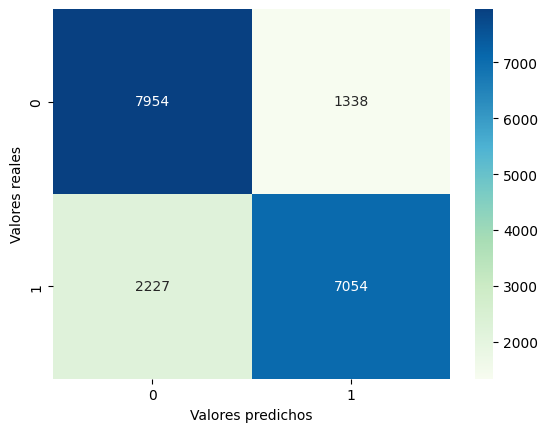

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

---

Armo el mismo modelo y predigo el dataset de test completo:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
model.fit(ds_train_norm, ds_hoteles_train_y, epochs=8)

Epoch 1/8
1935/1935 [==============================] - 12s 6ms/step - loss: 0.5049 - accuracy: 0.7461
Epoch 2/8
1935/1935 [==============================] - 4s 2ms/step - loss: 0.4365 - accuracy: 0.7772
Epoch 3/8
1935/1935 [==============================] - 5s 3ms/step - loss: 0.4208 - accuracy: 0.7874
Epoch 4/8
1935/1935 [==============================] - 4s 2ms/step - loss: 0.4133 - accuracy: 0.7933
Epoch 5/8
1935/1935 [==============================] - 4s 2ms/step - loss: 0.4075 - accuracy: 0.7975
Epoch 6/8
1935/1935 [==============================] - 4s 2ms/step - loss: 0.4026 - accuracy: 0.7995
Epoch 7/8
1935/1935 [==============================] - 6s 3ms/step - loss: 0.3977 - accuracy: 0.8044
Epoch 8/8
1935/1935 [==============================] - 4s 2ms/step - loss: 0.3952 - accuracy: 0.8059


In [ ]:
y_probs = model.predict(ds_test_norm)
y_pred  = np.argmax(y_probs, axis=-1)
y_pred

830/830 [==============================] - 1s 2ms/step


array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
df_submission_red_basica = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
df_submission_red_basica.to_csv('/content/drive/MyDrive/Tp_Datos_2023_2°/Submission_red_neuronal_basica.csv',index=False)

In [ ]:
df_submission_red_basica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           26535 non-null  object
 1   is_canceled  26535 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.7+ KB


## Definición de constructores de arquitecturas

Vamos a crear 4 diferentes arquitecturas de redes neuronales

In [ ]:
import keras
from keras.layers import Dropout
from keras.regularizers import l2

'''
-Tiene 2 hiperparámetros para optimizar: cant neuronas y capas ocultas
-Utiliza al optimizador 'adam'
-Utiliza la funcion de activación 'relu' en la capa de entrada y en las capas ocultas
-No tiene funcion de regularización
'''
def create_model_1(hidden_layers=1, neurons=32):
    optimizer = 'adam'  # Optimizador fijo para esta arquitectura
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_shape=(ds_train_norm.shape[1],), activation='relu'))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

'''
-Tiene 3 hiperparámetros para optimizar: cant neuronas y capas ocultas, optimizador
-Utiliza la funcion de activación 'relu' para la capa de entrada y la scapas ocultas
-No tienen regularizador
'''
def create_model_2(hidden_layers=2, neurons=64, optimizer='sgd'):
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_shape=(ds_train_norm.shape[1],), activation='relu'))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


'''
-Tiene 3 hiperparámetros para optimizar: cant neuronas, cant capas ocultas, valor del learning_rate
-Utiliza el optimizador SGD con un learning_rate paramétrico
-Utiliza el regulador L2 en la capa de entrada con un valor constante de learning_rate = 0.01
-Utiliza el regulador Dropout en las capas ocultas
-Utiliza el regulador L2 para la capa de salida,  con un learning_rate = 0.01
'''
def create_model_3(hidden_layers=1, neurons=128, ln_rate_parameter=0.01):
    # Optimizador SGD con learning rate variable
    optimizer = keras.optimizers.SGD(learning_rate=ln_rate_parameter)
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_shape=(ds_train_norm.shape[1],), activation='relu', kernel_regularizer=l2(0.01)))

    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu'))
        model.add(Dropout(0.2))  # Añado técnica de regularización por capa oculta

    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

'''
-Tiene 2 hiperparámetros para optimizar: cant neuronas y de capas ocultas
-Utiliza el optimizador rmsprop
-Utiliza el regulador L2 con un learning_rate=0.01 en la capa de entrada
-Las capas ocultas utilizan el regulador L2 y Dropout
'''
def create_model_4(hidden_layers=1, neurons=64):
    optimizer = 'rmsprop'  # Optimizador fijo para esta arquitectura
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_shape=(ds_train_norm.shape[1],), activation='relu', kernel_regularizer=l2(0.01)))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu', kernel_regularizer=l2(0.01))) #Añado regulizador L2 por cada capa
        model.add(Dropout(0.2))  # Añado técnica de regularización "DropOut" por cada capa oculta

    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Arquitectura 1

### Optimizacion de los hiperparámetros de la arquitectura 1

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
'''
-Tiene 2 hiperparámetros para optimizar: cant neuronas y capas ocultas
-Utiliza al optimizador 'adam'
-Utiliza la funcion de activación 'relu' en la capa de entrada y en las capas ocultas
-No tiene funcion de regularización
'''
def create_model_1(hidden_layers=1, neurons=32):
    optimizer = 'adam'  # Optimizador fijo para esta arquitectura
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_shape=(ds_train_norm.shape[1],), activation='relu'))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Optimizamos hiperparámetros de arquitectura

model = KerasClassifier(build_fn=create_model_1,callbacks=[early_stopping])
param_dist_architecture = {
    'neurons': [16, 32, 64, 128, 256, 512],
    'hidden_layers': [1, 2, 3, 4, 5, 6]
}

random_search_architecture = RandomizedSearchCV(estimator=model,
                                                param_distributions=param_dist_architecture,
                                                n_iter=4, cv=4, verbose = 4)

random_search_architecture.fit(ds_train_norm, ds_hoteles_train_y,callbacks=[early_stopping])

# Obtenemos los mejores hiperparámetros de arquitectura
best_architecture = random_search_architecture.best_params_



Fitting 4 folds for each of 4 candidates, totalling 16 fits
484/484 [==============================] - 1s 2ms/step - loss: 0.4380 - accuracy: 0.7819
[CV 1/4] END .......hidden_layers=6, neurons=32;, score=0.782 total time=   6.1s
484/484 [==============================] - 1s 2ms/step - loss: 0.4379 - accuracy: 0.7762
[CV 2/4] END .......hidden_layers=6, neurons=32;, score=0.776 total time=   6.7s
484/484 [==============================] - 1s 2ms/step - loss: 0.4344 - accuracy: 0.7801
[CV 3/4] END .......hidden_layers=6, neurons=32;, score=0.780 total time=   5.5s
484/484 [==============================] - 1s 2ms/step - loss: 0.4472 - accuracy: 0.7706
[CV 4/4] END .......hidden_layers=6, neurons=32;, score=0.771 total time=   8.2s
484/484 [==============================] - 1s 2ms/step - loss: 0.4363 - accuracy: 0.7822
[CV 1/4] END .......hidden_layers=2, neurons=64;, score=0.782 total time=   5.0s
484/484 [==============================] - 1s 2ms/step - loss: 0.4343 - accuracy: 0.7779
[

In [ ]:
best_architecture

{'neurons': 128, 'hidden_layers': 2}

Podemos ver que el mejor modelo para la arquitectura 1 tiene cantidad de neuronas igual a 128 y 2 capas ocultas

In [ ]:
# Creamos el mejor modelo
best_model = create_model_1(neurons=best_architecture['neurons'], hidden_layers=best_architecture['hidden_layers'])

# Optimizamos hiperparámetros de entrenamiento
param_dist_training = {
    'epochs': [10, 20, 30, 40],
    'batch_size': [20, 25, 30, 35]
}

random_search_training = RandomizedSearchCV(estimator=KerasClassifier(build_fn=lambda: best_model),
                                            param_distributions=param_dist_training,
                                            n_iter=4,
                                            cv=3, verbose = 4)

random_search_training.fit(ds_train_norm, ds_hoteles_train_y,callbacks=[early_stopping])

# Obtenemos los mejores hiperparámetros
best_training = random_search_training.best_params_

# Entrenamos el modelo con el dataset completo
best_model.fit(ds_train_norm, ds_hoteles_train_y, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# Obtenemos predicciones
y_probs = best_model.predict(ds_test_norm)
y_predictions = (y_probs > 0.5).astype(int)

y_pred = np.ravel(y_predictions)

# Unimos las predicciones con su id para realizar el subbmit en Kaggle
df_submission = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
df_submission.to_csv('Submission_red_neuronal_model_optimized.csv', index=False)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/20
1651/1651 [==============================] - 4s 2ms/step - loss: 0.4631 - accuracy: 0.7606
Epoch 2/20
1651/1651 [==============================] - 4s 2ms/step - loss: 0.4226 - accuracy: 0.7865
Epoch 3/20
1651/1651 [==============================] - 4s 3ms/step - loss: 0.4090 - accuracy: 0.7935
Epoch 4/20
1651/1651 [==============================] - 3s 2ms/step - loss: 0.3999 - accuracy: 0.7994
Epoch 5/20
1651/1651 [==============================] - 3s 2ms/step - loss: 0.3941 - accuracy: 0.8028
Epoch 6/20
1651/1651 [==============================] - 4s 3ms/step - loss: 0.3878 - accuracy: 0.8063
Epoch 7/20
1651/1651 [==============================] - 4s 3ms/step - loss: 0.3831 - accuracy: 0.8105
Epoch 8/20
1651/1651 [==============================] - 3s 2ms/step - loss: 0.3774 - accuracy: 0.8113
Epoch 9/20
1651/1651 [==============================] - 3s 2ms/step - loss: 0.3728 - accuracy: 0.8158
Epoch 10/20
1651/1651 [

In [ ]:
best_training = random_search_training.best_params_
best_training
# {'epochs': 20, 'batch_size': 30}

{'epochs': 20, 'batch_size': 30}

### Creamos la matriz de confusión para el mejor modelo




In [ ]:
# Entrenamos el modelo con el dataset completo
best_model.fit(x_train_norm, y_train, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# Obtenemos predicciones
y_probs = best_model.predict(x_test_norm)
y_predictions = (y_probs > 0.5).astype(int)

y_pred = np.ravel(y_predictions)

print(classification_report(y_test,y_pred))

Epoch 1/20
1445/1445 [==============================] - 3s 2ms/step - loss: 3.5353 - accuracy: 0.7589
Epoch 2/20
1445/1445 [==============================] - 8s 6ms/step - loss: 3.2300 - accuracy: 0.7774
Epoch 3/20
1445/1445 [==============================] - 3s 2ms/step - loss: 3.0780 - accuracy: 0.7841
Epoch 4/20
1445/1445 [==============================] - 3s 2ms/step - loss: 2.8229 - accuracy: 0.7860
Epoch 5/20
1445/1445 [==============================] - 3s 2ms/step - loss: 2.3202 - accuracy: 0.7693
Epoch 6/20
1445/1445 [==============================] - 5s 3ms/step - loss: 1.8014 - accuracy: 0.7455
Epoch 7/20
1445/1445 [==============================] - 4s 2ms/step - loss: 1.3836 - accuracy: 0.7211
Epoch 8/20
1445/1445 [==============================] - 3s 2ms/step - loss: 1.1283 - accuracy: 0.7149
Epoch 9/20
1445/1445 [==============================] - 3s 2ms/step - loss: 0.9767 - accuracy: 0.7122
Epoch 10/20
1445/1445 [==============================] - 4s 3ms/step - loss: 0.881

Text(50.722222222222214, 0.5, 'Valores reales')

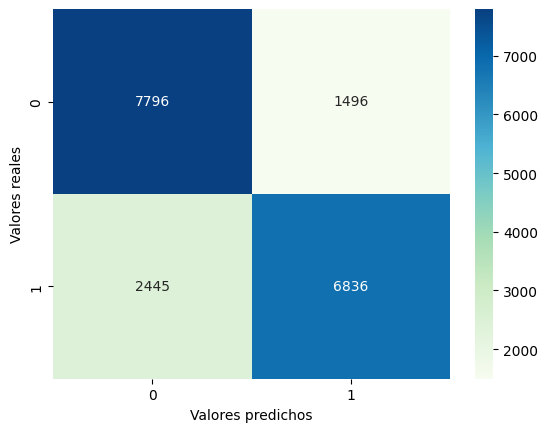

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

### Exportamos las predicciones para la submission

In [ ]:
# Entrenamos el modelo con el dataset completo
best_model.fit(ds_train_norm, ds_hoteles_train_y, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# Obtenemos predicciones
y_probs = best_model.predict(ds_test_norm)
y_predictions = (y_probs > 0.5).astype(int)

y_pred = np.ravel(y_predictions)

# Unimos las predicciones con su id para realizar el subbmit en Kaggle
df_submission = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
df_submission.to_csv('Submission_red_neuronal_modelo1_optimized_v2.csv', index=False)

Epoch 1/20
2064/2064 [==============================] - 5s 2ms/step - loss: 0.4613 - accuracy: 0.7755
Epoch 2/20
2064/2064 [==============================] - 6s 3ms/step - loss: 0.4121 - accuracy: 0.7988
Epoch 3/20
2064/2064 [==============================] - 5s 2ms/step - loss: 0.3931 - accuracy: 0.8076
Epoch 4/20
2064/2064 [==============================] - 5s 2ms/step - loss: 0.3820 - accuracy: 0.8146
Epoch 5/20
2064/2064 [==============================] - 6s 3ms/step - loss: 0.3716 - accuracy: 0.8183
Epoch 6/20
2064/2064 [==============================] - 5s 2ms/step - loss: 0.3651 - accuracy: 0.8224
Epoch 7/20
2064/2064 [==============================] - 5s 2ms/step - loss: 0.3583 - accuracy: 0.8256
Epoch 8/20
2064/2064 [==============================] - 6s 3ms/step - loss: 0.3531 - accuracy: 0.8285
Epoch 9/20
2064/2064 [==============================] - 5s 2ms/step - loss: 0.3489 - accuracy: 0.8310
Epoch 10/20
2064/2064 [==============================] - 5s 2ms/step - loss: 0.345

## Arquitectura 2

### Optimización de hiperparámetros de la arquitectura 2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Definimos función para crear el modelo
'''
-Tiene 3 hiperparámetros para optimizar: cant neuronas y capas ocultas, optimizador
-Utiliza la funcion de activación 'relu' para la capa de entrada y la scapas ocultas
-No tienen regularizador
'''
def create_model_2(hidden_layers=2, neurons=64, optimizer='sgd'):
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_shape=(ds_train_norm.shape[1],), activation='relu'))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



# Optimizamos hiperparámetros de arquitectura
model = KerasClassifier(build_fn=create_model_2,callbacks=[early_stopping])
param_dist_architecture = {
    'neurons': [16, 32, 64, 128],
    'hidden_layers': [1, 2, 3],
    'optimizer': ['sgd', 'adam', 'rmsprop', 'adagrad']
}

random_search_architecture = RandomizedSearchCV(estimator=model,
                                                param_distributions=param_dist_architecture,
                                                n_iter=1, cv=2)
random_search_architecture.fit(ds_train_norm, ds_hoteles_train_y)

# Obtenemos los mejor hiperparámetros de arquitectura
best_architecture = random_search_architecture.best_params_

# Creamos un modelo con ellos
best_model = create_model_2(neurons=best_architecture['neurons'], hidden_layers=best_architecture['hidden_layers'], optimizer = best_architecture['optimizer'])

# Optimizamos epochs y batch_size
param_dist_training = {
    'epochs': [10, 20, 30],
    'batch_size': [20, 25, 30]
}

random_search_training = RandomizedSearchCV(estimator=KerasClassifier(build_fn=lambda: best_model), param_distributions=param_dist_training, n_iter=3, cv=3)
random_search_training.fit(ds_train_norm, ds_hoteles_train_y)

# Obtenemos los mejores hiperparámetros
best_training = random_search_training.best_params_

# Entrenamos el modelo
best_model.fit(ds_train_norm, ds_hoteles_train_y, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# Hacemos predicciones con el dataset completo
y_probs = best_model.predict(ds_test_norm)
y_predictions = (y_probs > 0.5).astype(int)

y_pred = np.ravel(y_predictions)

# Realizamos el subbmit a Kaggle
df_submission = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
df_submission.to_csv('Submission_red_neuronal_model2_optimized.csv', index=False)

1935/1935 [==============================] - 5s 2ms/step - loss: 0.6491 - accuracy: 0.6313
Epoch 1/20
1651/1651 [==============================] - 4s 2ms/step - loss: 0.6675 - accuracy: 0.5766
Epoch 2/20
1651/1651 [==============================] - 3s 2ms/step - loss: 0.6343 - accuracy: 0.6326
Epoch 3/20
1651/1651 [==============================] - 5s 3ms/step - loss: 0.6126 - accuracy: 0.6588
Epoch 4/20
1651/1651 [==============================] - 3s 2ms/step - loss: 0.5955 - accuracy: 0.6738
Epoch 5/20
1651/1651 [==============================] - 3s 2ms/step - loss: 0.5817 - accuracy: 0.6851
Epoch 6/20
1651/1651 [==============================] - 3s 2ms/step - loss: 0.5704 - accuracy: 0.6933
Epoch 7/20
1651/1651 [==============================] - 4s 3ms/step - loss: 0.5611 - accuracy: 0.6978
Epoch 8/20
1651/1651 [==============================] - 4s 3ms/step - loss: 0.5536 - accuracy: 0.7014
Epoch 9/20
1651/1651 [==============================] - 3s 2ms/step - loss: 0.5475 - accuracy

### Parametros utilizados

In [ ]:
best_architecture

{'optimizer': 'sgd', 'neurons': 128, 'hidden_layers': 2}

In [ ]:
best_training

{'epochs': 10, 'batch_size': 20}

### Hacemos la matriz de confusion


Epoch 1/10
1734/1734 [==============================] - 5s 3ms/step - loss: 0.4700 - accuracy: 0.7658
Epoch 2/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4690 - accuracy: 0.7662
Epoch 3/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4681 - accuracy: 0.7665
Epoch 4/10
1734/1734 [==============================] - 5s 3ms/step - loss: 0.4673 - accuracy: 0.7667
Epoch 5/10
1734/1734 [==============================] - 5s 3ms/step - loss: 0.4666 - accuracy: 0.7670
Epoch 6/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4659 - accuracy: 0.7671
Epoch 7/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4652 - accuracy: 0.7678
Epoch 8/10
1734/1734 [==============================] - 6s 3ms/step - loss: 0.4645 - accuracy: 0.7681
Epoch 9/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4639 - accuracy: 0.7683
Epoch 10/10
581/581 [==============================] - 1s 1ms/step
              p

Text(50.722222222222214, 0.5, 'Valores reales')

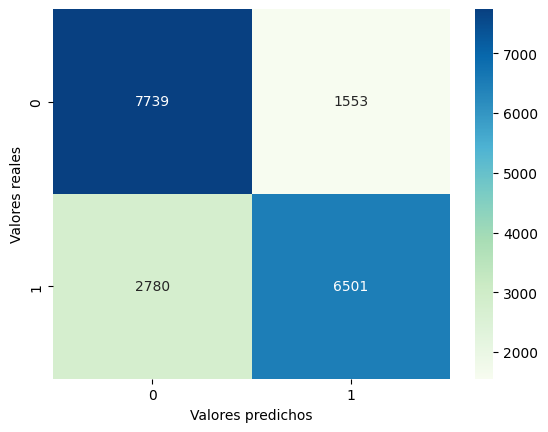

In [ ]:
best_training = random_search_training.best_params_
best_training
# Entrenamos el modelo con el dataset completo
best_model.fit(x_train_norm, y_train, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# Obtenemos predicciones
y_probs = best_model.predict(x_test_norm)
y_predictions = (y_probs > 0.5).astype(int)  # Assuming binary classification

y_pred = np.ravel(y_predictions)

print(classification_report(y_test,y_pred))
# {'epochs': 20, 'batch_size': 30}

#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

### Pruebo con mas cv's, más combinaciones aleatorias, valores mas bajos de batch_size

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Definimos función para crear el modelo
'''
-Tiene 3 hiperparámetros para optimizar: cant neuronas y capas ocultas, optimizador
-Utiliza la funcion de activación 'relu' para la capa de entrada y la scapas ocultas
-No tienen regularizador
'''
def create_model_2(hidden_layers=2, neurons=64, optimizer='sgd'):
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_shape=(ds_train_norm.shape[1],), activation='relu'))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



# Optimizamos hiperparámetros de arquitectura
model = KerasClassifier(build_fn=create_model_2,callbacks=[early_stopping])
param_dist_architecture = {
    'neurons': [16, 32, 64, 128],
    'hidden_layers': [1, 2, 3],
    'optimizer': ['sgd', 'adam', 'rmsprop', 'adagrad']
}

random_search_architecture = RandomizedSearchCV(estimator=model,
                                                param_distributions=param_dist_architecture,
                                                n_iter=5, cv=4)
random_search_architecture.fit(ds_train_norm, ds_hoteles_train_y)

# Obtenemos los mejor hiperparámetros de arquitectura
best_architecture = random_search_architecture.best_params_

# Creamos un modelo con ellos
best_model = create_model_2(neurons=best_architecture['neurons'], hidden_layers=best_architecture['hidden_layers'], optimizer = best_architecture['optimizer'])

# Optimizamos epochs y batch_size
param_dist_training = {
    'epochs': [10, 20, 30],
    'batch_size': [10, 15, 20]
}

random_search_training = RandomizedSearchCV(estimator=KerasClassifier(build_fn=lambda: best_model), param_distributions=param_dist_training, n_iter=4, cv=6)
random_search_training.fit(ds_train_norm, ds_hoteles_train_y)

# Obtenemos los mejores hiperparámetros
best_training = random_search_training.best_params_

# Entrenamos el modelo
best_model.fit(ds_train_norm, ds_hoteles_train_y, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# Hacemos predicciones con el dataset completo
y_probs = best_model.predict(ds_test_norm)
y_predictions = (y_probs > 0.5).astype(int)

y_pred = np.ravel(y_predictions)

# Realizamos el subbmit a Kaggle
df_submission = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
df_submission.to_csv('Submission_red_neuronal_model2_optimized.csv', index=False)

1935/1935 [==============================] - 3s 1ms/step - loss: 0.4964 - accuracy: 0.7486
Epoch 1/20
3440/3440 [==============================] - 4s 1ms/step - loss: 0.4871 - accuracy: 0.7502
Epoch 2/20
3440/3440 [==============================] - 4s 1ms/step - loss: 0.4465 - accuracy: 0.7744
Epoch 3/20
3440/3440 [==============================] - 6s 2ms/step - loss: 0.4366 - accuracy: 0.7792
Epoch 4/20
3440/3440 [==============================] - 5s 1ms/step - loss: 0.4313 - accuracy: 0.7826
Epoch 5/20
3440/3440 [==============================] - 4s 1ms/step - loss: 0.4276 - accuracy: 0.7852
Epoch 6/20
3440/3440 [==============================] - 4s 1ms/step - loss: 0.4246 - accuracy: 0.7877
Epoch 7/20
3440/3440 [==============================] - 4s 1ms/step - loss: 0.4228 - accuracy: 0.7883
Epoch 8/20
3440/3440 [==============================] - 4s 1ms/step - loss: 0.4211 - accuracy: 0.7914
Epoch 9/20
3440/3440 [==============================] - 6s 2ms/step - loss: 0.4188 - accuracy

## Arquitectura 3

### Optimización de los hiperparámetros de la arquitectura 3

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint
from keras.regularizers import l2
from sklearn.metrics import f1_score




def create_model_3(hidden_layers=1, neurons=128, ln_rate_parameter=0.01):
    # Optimizador SGD con learning rate variable
    optimizer = keras.optimizers.SGD(learning_rate=ln_rate_parameter)
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_shape=(ds_train_norm.shape[1],), activation='relu', kernel_regularizer=l2(0.01)))

    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu'))
        model.add(Dropout(0.2))  # Añado técnica de regularización por capa oculta

    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model



early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


# Optimizamos hiperparámetros de arquitectura
model = KerasClassifier(build_fn=create_model_3,callbacks=[early_stopping])
param_dist_architecture = {
    'neurons': [16, 32, 64, 128],
    'hidden_layers': [1, 2, 3],
    'ln_rate_parameter':[0.001, 0.005, 0.0001, 0.01]
}

random_search_architecture = RandomizedSearchCV(estimator=model,
                                                param_distributions=param_dist_architecture,
                                                n_iter=7, cv=3)
random_search_architecture.fit(ds_train_norm, ds_hoteles_train_y)

#Obtenemos los mejores
best_architecture = random_search_architecture.best_params_

# Creamos un modelo con ellos
best_model = create_model_3(neurons=best_architecture['neurons'], hidden_layers=best_architecture['hidden_layers'],ln_rate_parameter=best_architecture['ln_rate_parameter'])

# Optimizamos hiperparámetros de entrenamiento
param_dist_training = {
    'epochs': [10, 20, 30],
    'batch_size': [20, 25, 30]
}

random_search_training = RandomizedSearchCV(estimator=KerasClassifier(build_fn=lambda: best_model), param_distributions=param_dist_training, n_iter=3, cv=3)
random_search_training.fit(ds_train_norm, ds_hoteles_train_y)

# Obtenemos los mejores
best_training = random_search_training.best_params_

# Entrenamos el dataset completo
best_model.fit(ds_train_norm, ds_hoteles_train_y, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# Hacemos predicciones
y_probs = best_model.predict(ds_test_norm)
y_predictions = (y_probs > 0.5).astype(int)  # Assuming binary classification

y_pred = np.ravel(y_predictions)

# Realizamos subbmit a Kaggle
df_submission_model_3_optimized = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
df_submission_model_3_optimized.to_csv('Submission_red_neuronal_model_3_optimized.csv', index=False)

1935/1935 [==============================] - 6s 3ms/step - loss: 0.9308 - accuracy: 0.6522
Epoch 1/30
2064/2064 [==============================] - 5s 2ms/step - loss: 0.9167 - accuracy: 0.6666
Epoch 2/30
2064/2064 [==============================] - 5s 3ms/step - loss: 0.7212 - accuracy: 0.7128
Epoch 3/30
2064/2064 [==============================] - 4s 2ms/step - loss: 0.6460 - accuracy: 0.7272
Epoch 4/30
2064/2064 [==============================] - 4s 2ms/step - loss: 0.6139 - accuracy: 0.7327
Epoch 5/30
2064/2064 [==============================] - 5s 3ms/step - loss: 0.5999 - accuracy: 0.7363
Epoch 6/30
2064/2064 [==============================] - 5s 2ms/step - loss: 0.5935 - accuracy: 0.7378
Epoch 7/30
2064/2064 [==============================] - 4s 2ms/step - loss: 0.5908 - accuracy: 0.7376
Epoch 8/30
2064/2064 [==============================] - 8s 4ms/step - loss: 0.5895 - accuracy: 0.7380
Epoch 9/30
2064/2064 [==============================] - 6s 3ms/step - loss: 0.5889 - accuracy

### Parametros utilizados

In [ ]:
best_training

{'epochs': 30, 'batch_size': 25}

In [ ]:
best_architecture

{'neurons': 128, 'ln_rate_parameter': 0.01, 'hidden_layers': 1}

### Hacemos la matriz de confusion

In [ ]:
best_training = random_search_training.best_params_
best_training
# Entrenamos el modelo con el dataset completo
best_model.fit(x_train_norm, y_train, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# Obtenemos predicciones
y_probs = best_model.predict(x_test_norm)
y_predictions = (y_probs > 0.5).astype(int)  # Assuming binary classification

y_pred = np.ravel(y_predictions)

print(classification_report(y_test,y_pred))
# {'epochs': 20, 'batch_size': 30}

Epoch 1/10
1734/1734 [==============================] - 5s 3ms/step - loss: 0.6267 - accuracy: 0.7344
Epoch 2/10
1734/1734 [==============================] - 5s 3ms/step - loss: 0.5780 - accuracy: 0.7412
Epoch 3/10
1734/1734 [==============================] - 5s 3ms/step - loss: 0.5512 - accuracy: 0.7453
Epoch 4/10
1734/1734 [==============================] - 5s 3ms/step - loss: 0.5339 - accuracy: 0.7493
Epoch 5/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.5216 - accuracy: 0.7519
Epoch 6/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.5124 - accuracy: 0.7535
Epoch 7/10
1734/1734 [==============================] - 5s 3ms/step - loss: 0.5051 - accuracy: 0.7551
Epoch 8/10
1734/1734 [==============================] - 4s 3ms/step - loss: 0.4993 - accuracy: 0.7563
Epoch 9/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4946 - accuracy: 0.7577
Epoch 10/10
581/581 [==============================] - 1s 1ms/step
              p

Text(50.722222222222214, 0.5, 'Valores reales')

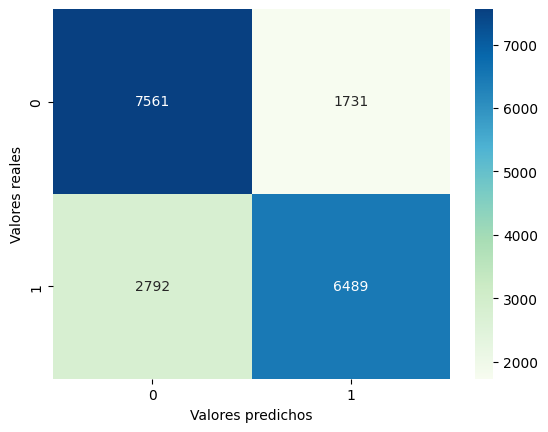

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')

In [ ]:
# # Entrenamos el modelo con el dataset completo
# best_model.fit(x_train_norm, y_train, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# # Obtenemos predicciones
# y_probs = best_model.predict(x_test_norm)
# y_predictions = (y_probs > 0.5).astype(int)  # Assuming binary classification

# y_pred = np.ravel(y_predictions)

# print(classification_report(y_test,y_pred))

## Arquitectura 4

### Optimización de los hiperparámetros de la arquitectura 4

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint
from keras.regularizers import l2

'''
-Tiene 2 hiperparámetros para optimizar: cant neuronas y de capas ocultas
-Utiliza el optimizador rmsprop
-Utiliza el regulador L2 con un learning_rate=0.01 en la capa de entrada
-Las capas ocultas utilizan el regulador L2 y Dropout
'''
def create_model_4(hidden_layers=1, neurons=64):
    optimizer = 'rmsprop'  # Optimizador fijo para esta arquitectura
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons, input_shape=(ds_train_norm.shape[1],), activation='relu', kernel_regularizer=l2(0.01)))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons, activation='relu', kernel_regularizer=l2(0.01))) #Añado regulizador L2 por cada capa
        model.add(Dropout(0.2))  # Añado técnica de regularización "DropOut" por cada capa oculta

    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Optimizamos hiperparáemtros de arquitectura
model = KerasClassifier(build_fn=create_model_4,callbacks=[early_stopping])
param_dist_architecture = {
    'neurons': [16, 32, 64, 128],
    'hidden_layers': [1, 2, 3],
}

random_search_architecture = RandomizedSearchCV(estimator=model,
                                                param_distributions=param_dist_architecture,
                                                n_iter=5, cv=5)
random_search_architecture.fit(ds_train_norm, ds_hoteles_train_y)

# Obtenemos los mejores
best_architecture = random_search_architecture.best_params_

# Creamos un modelo con esos hiperparámetros
best_model = create_model_4(neurons=best_architecture['neurons'], hidden_layers=best_architecture['hidden_layers'])

# Optimizamos hiperparámetros de entrenamiento
param_dist_training = {
    'epochs': [10, 20, 30],
    'batch_size': [20, 25, 30]
}

random_search_training = RandomizedSearchCV(estimator=KerasClassifier(build_fn=lambda: best_model), param_distributions=param_dist_training, n_iter=3, cv=4)
random_search_training.fit(ds_train_norm, ds_hoteles_train_y)

# Obtenemos los mejores
best_training = random_search_training.best_params_

# Entrenamos con el dataset completo
best_model.fit(ds_train_norm, ds_hoteles_train_y, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# Hacemos predicciones con test
y_probs = best_model.predict(ds_test_norm)
y_predictions = (y_probs > 0.5).astype(int)  # Assuming binary classification

y_pred = np.ravel(y_predictions)

# Realizamos subbmit en Kaggle
df_submission = pd.DataFrame({'id': ds_hoteles_test['id'], 'is_canceled': y_pred})
df_submission.to_csv('Submission_red_neuronal_model4_optimized.csv', index=False)

1935/1935 [==============================] - 6s 3ms/step - loss: 0.6202 - accuracy: 0.7143
Epoch 1/20
1548/1548 [==============================] - 4s 2ms/step - loss: 0.6301 - accuracy: 0.7192
Epoch 2/20
1548/1548 [==============================] - 3s 2ms/step - loss: 0.5911 - accuracy: 0.7343
Epoch 3/20
1548/1548 [==============================] - 5s 3ms/step - loss: 0.5891 - accuracy: 0.7349
Epoch 4/20
1548/1548 [==============================] - 3s 2ms/step - loss: 0.5887 - accuracy: 0.7358
Epoch 5/20
1548/1548 [==============================] - 3s 2ms/step - loss: 0.5885 - accuracy: 0.7358
Epoch 6/20
1548/1548 [==============================] - 3s 2ms/step - loss: 0.5885 - accuracy: 0.7348
Epoch 7/20
1548/1548 [==============================] - 4s 3ms/step - loss: 0.5884 - accuracy: 0.7348
Epoch 8/20
1548/1548 [==============================] - 4s 3ms/step - loss: 0.5883 - accuracy: 0.7350
Epoch 9/20
1548/1548 [==============================] - 3s 2ms/step - loss: 0.5880 - accuracy

---

### Parametros utilizados

In [ ]:
best_training

{'epochs': 2, 'batch_size': 10}

In [ ]:
best_architecture

{'neurons': 64, 'hidden_layers': 2}

{'epochs': 2, 'batch_size': 10}{'neurons': 64, 'hidden_layers': 2}

### Matriz de confusion

Epoch 1/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4873 - accuracy: 0.7614
Epoch 2/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4845 - accuracy: 0.7620
Epoch 3/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4820 - accuracy: 0.7622
Epoch 4/10
1734/1734 [==============================] - 6s 4ms/step - loss: 0.4799 - accuracy: 0.7627
Epoch 5/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4780 - accuracy: 0.7636
Epoch 6/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4763 - accuracy: 0.7638
Epoch 7/10
1734/1734 [==============================] - 5s 3ms/step - loss: 0.4748 - accuracy: 0.7641
Epoch 8/10
1734/1734 [==============================] - 5s 3ms/step - loss: 0.4734 - accuracy: 0.7649
Epoch 9/10
1734/1734 [==============================] - 4s 2ms/step - loss: 0.4722 - accuracy: 0.7650
Epoch 10/10
581/581 [==============================] - 1s 1ms/step
              p

Text(50.722222222222214, 0.5, 'Valores reales')

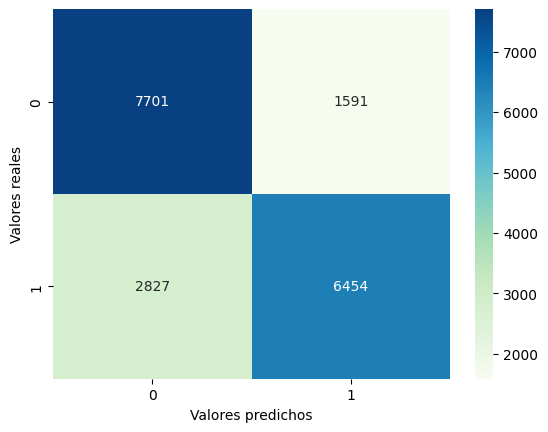

In [ ]:
best_training = random_search_training.best_params_
best_training
# Entrenamos el modelo con el dataset completo
best_model.fit(x_train_norm, y_train, epochs=best_training['epochs'], batch_size=best_training['batch_size'])

# Obtenemos predicciones
y_probs = best_model.predict(x_test_norm)
y_predictions = (y_probs > 0.5).astype(int)  # Assuming binary classification

y_pred = np.ravel(y_predictions)

print(classification_report(y_test,y_pred))
# {'epochs': 20, 'batch_size': 30}

#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')